# Visual Question Answering (VQA) Implementation

This notebook serves as the main implementation for the Visual Question Answering (VQA) project. It includes all the necessary code for data loading, model training, evaluation, and demonstration.


# AlexNet is used in place of VGGNet

In [1]:
import torch, nltk
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.corpus import wordnet
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import pandas as pd
import os, re, json

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
if not os.path.exists('/usr/share/nltk_data/corpora/wordnet'):
    !unzip '/usr/share/nltk_data/corpora/wordnet.zip' -d '/usr/share/nltk_data/corpora'

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
input_path = '/kaggle/input/mmdp-vqa'
images_path = os.path.join(input_path, 'images')

In [4]:
from torchvision import models
import torchvision
from torch import nn

In [5]:
class VQAModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(VQAModel, self).__init__()

        self.image_embedding = torchvision.models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
        self.image_embedding.classifier = self.image_embedding.classifier[:-1]
        self.fc1 = nn.Linear(4096, 1024)
        
        
        self.vocab_size = kwargs.pop("vocab_size", 2048)
        self.embedding_size = kwargs.pop("embedding_size", 300)
        self.hidden_size = kwargs.pop("hidden_size", 1024)
        self.lstm_layers = kwargs.pop("lstm_layers", 1)
        self.classes = kwargs.pop("classes", 1024)
        self.sequence_length = kwargs.pop("sequence_length", 30)
        
        self.text_embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.lstm = nn.LSTM(input_size = self.embedding_size, hidden_size = self.hidden_size, num_layers  = self.lstm_layers, batch_first = True)
        self.fc2 = nn.Linear(self.hidden_size * self.sequence_length, 1024)
        
        self.classifier = nn.Linear(1024, self.classes)
        
    def forward(self, images, prompts):
        image_features = self.image_embedding(images) # (batch_size, 3, 224, 224)
        image_features = self.fc1(image_features) # (batch_size, 4096)
        
        text_features = self.text_embedding(prompts) # (batch_size, max_length, embedding_size)
        text_features, (_, _) = self.lstm(text_features) # (batch_size, max_length, hidden_size)
        
        text_features = text_features.contiguous().view(text_features.size(0), -1)

        text_features = self.fc2(text_features) # (batch_size, max_length, 1024)
        
        features = torch.mul(image_features, text_features)
        features = self.classifier(features)
        
        return features

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class VQAModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(VQAModel, self).__init__()

        self.image_embedding = models.alexnet(pretrained=True) # Load pre-trained AlexNet
        # Modify the last layer to match the output size
        num_ftrs = self.image_embedding.classifier[-1].in_features
        self.image_embedding.classifier[-1] = nn.Linear(num_ftrs, 1024) # Output size 1024
        
        self.fc1 = nn.Linear(1024, 1024) # Modify this to match the output size of AlexNet
        
        self.vocab_size = kwargs.pop("vocab_size", 2048)
        self.embedding_size = kwargs.pop("embedding_size", 300)
        self.hidden_size = kwargs.pop("hidden_size", 1024)
        self.lstm_layers = kwargs.pop("lstm_layers", 1)
        self.classes = kwargs.pop("classes", 1024)
        self.sequence_length = kwargs.pop("sequence_length", 30)
        
        self.text_embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=self.lstm_layers, batch_first=True)
        self.fc2 = nn.Linear(self.hidden_size * self.sequence_length, 1024)
        
        self.classifier = nn.Linear(1024, self.classes)
        
    def forward(self, images, prompts):
        image_features = self.image_embedding(images) # (batch_size, 1000)
        image_features = self.fc1(image_features) # (batch_size, 1024)
        
        text_features = self.text_embedding(prompts) # (batch_size, max_length, embedding_size)
        text_features, (_, _) = self.lstm(text_features) # (batch_size, max_length, hidden_size)
        
        text_features = text_features.contiguous().view(text_features.size(0), -1)

        text_features = self.fc2(text_features) # (batch_size, max_length, 1024)
        
        features = torch.mul(image_features, text_features)
        features = self.classifier(features)
        
        return features


In [7]:
def wups(wa, wb):
    if type(wa) == str:
        wa = wordnet.synsets(wa)
        
    if type(wb) == str:
        wb = wordnet.synsets(wb)
        
    score = 0
    
    for i in wa:
        for j in wb:
            x = i.wup_similarity(j)
            if x is not None: score = max(score, x)

    return score

In [8]:
__redundants_pattern = re.compile("( (in |on |of )?(the |this )?(image\d*) \?)")

def load_statements(file):
    with open(file, 'r') as fp:
        statements = fp.read().splitlines()
        
    df = pd.DataFrame({"question": [], "answer": [], "image_id":[]})
    for i in range(0, len(statements), 2):
        img_id = __redundants_pattern.findall(statements[i])[0][3]
        question = statements[i].replace(__redundants_pattern.findall(statements[i])[0][0], "")
        record = {
            "question": question,
            "answer": statements[i+1],
            "image_id": img_id,
        }
        df = df.append(record, ignore_index=True)
    
    return df

def get_answer_space(df: pd.DataFrame) -> list:
    answer_space = []
    for ans in df.answer.to_list():
        answer_space += [ans] if "," not in ans else ans.replace(" ", "").split(",")
        
    answer_space = list(set(answer_space))
    answer_space.sort()
    
    return answer_space

def split_df(df, test_size = 0.2, train_out = None, test_out = None):
    train_df, test_df = train_test_split(df, test_size=test_size)

    if train_out is not None:
        train_df.to_csv(train_out, index=False)
    
    if test_out is not None:
        test_df.to_csv(test_out, index=False)
        
    return train_df, test_df

In [9]:
data_files = {
    "train": os.path.join(input_path, 'train.csv'),
    "test": os.path.join(input_path, 'test.csv')
}

In [10]:
train_df, test_df = pd.read_csv(data_files['train']), pd.read_csv(data_files['test'])

In [11]:
train_df

,question,answer,image_id
0,what is the green object on the floor,basket,image519
1,what is at the left of the candelabra,window,image1324
2,what is on the drawer,towel,image573
3,what is to right of bed,window,image515
4,what is behind the tissue roll,bottle_of_liquid,image820
...,...,...,...
9969,what is the object close to the sink,faucet,image682
9970,how many lights are on,3,image22
9971,what are found on the table,"lamp, tissue_box",image1094
9972,what is to the left of the box,shelves,image181


In [12]:
word_2_idx, idx_2_word = {}, {}
answer_2_idx, idx_2_answer = {}, {}
max_length_question = 0
words_counter, answer_counter = 0, 0

for line in train_df['question']:
    line = word_tokenize(line.lower())
    max_length_question = max(max_length_question, len(line))
    for i in line:
        if i not in word_2_idx:
            word_2_idx[i], idx_2_word[words_counter] = words_counter, i
            words_counter += 1

for line in test_df['question']:
    line = word_tokenize(line.lower())
    max_length_question = max(max_length_question, len(line))
    for i in line:
        if i not in word_2_idx:
            word_2_idx[i], idx_2_word[words_counter] = words_counter, i
            words_counter += 1
        
for line in train_df['answer']:
    line = word_tokenize(line.lower())
    for i in line:
        if i not in answer_2_idx:
            answer_2_idx[i], idx_2_answer[answer_counter] = answer_counter, i
            answer_counter += 1
        
for line in test_df['answer']:
    line = word_tokenize(line.lower())
    for i in line:
        if i not in answer_2_idx:
            answer_2_idx[i], idx_2_answer[answer_counter] = answer_counter, i
            answer_counter += 1


words = [None] * len(word_2_idx)

for word, index in word_2_idx.items():
    words[index] = word

answers = [None] * len(answer_2_idx)
for word, index in answer_2_idx.items():
    answers[index] = word
    
with open('dictionaries.txt', 'w') as fp:
    fp.write('\n'.join(words))
    
with open('answers-index.txt', 'w') as fp:
    fp.write('\n'.join(answers))
    

max_length_question = max_length_question * 4 // 3
answer_space_length = len(answer_2_idx)
words_length = len(word_2_idx)

In [13]:
def convert_question(s: str):
    res = [word_2_idx.get(item, len(word_2_idx)) for item in word_tokenize(s.lower())]
    res += [len(word_2_idx)] * (max_length_question - len(res))
    return res

def convert_answer(s: str):
    answer = [0] * (answer_space_length + 1)
    for idx in [answer_2_idx.get(item, len(word_2_idx)) for item in word_tokenize(s.lower())]:
        answer[idx] = 1
    return answer

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
model = VQAModel(
    vocab_size = words_length + 1, # +1 for the mistake
    sequence_length = max_length_question, 
    hidden_size = 512, 
    lstm_layers = 2, 
    classes = answer_space_length + 1, # +1 for the mistake
    embedding_size = 512
)

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 169MB/s]  


In [18]:
epochs = 10
initial_lr = 1e-5

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [20]:
class QADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, *args, **kwargs):
        self.dataset = dataset
        self.transform, self.question_preprocess, self.answer_preprocess = \
            kwargs.pop("transform", None), kwargs.pop("question_preprocess", None), \
            kwargs.pop("answer_preprocess", None)
        self.image_root = kwargs.pop("image_root", None)
        assert self.image_root is not None, "Image root is not defined"
        self.images_path, self.question, self.answer = self.load()
        self.to_tensor = torchvision.transforms.ToTensor()
        
    def load(self):
        images_path, question, answer = [], [], []
        
        for item in self.dataset:
            images_path += [item["image_id"]]
            question += [item["question"]]
            answer += [item["answer"]]
            
        images_path = [os.path.join(self.image_root, f'{id}.png') for id in images_path]

        if self.question_preprocess:
            question = [self.question_preprocess(item) for item in question]

        if self.answer_preprocess:
            answer = [self.answer_preprocess(item) for item in answer]
                    
        return images_path, question, answer
    
    def __len__(self):
        return len(self.images_path)
    
    def max_length(self):
        return self.max_lengthmax
    
    def __getitem__(self, index):
        image_data = Image.open(self.images_path[index]).convert("RGB")
        
        if self.transform:
            image_data = self.transform(image_data)
            
        if type(image_data) is not torch.Tensor:
            image_data = self.to_tensor(image_data)
                
        return image_data, torch.tensor(self.question[index], dtype = torch.long), torch.tensor(self.answer[index], dtype = torch.float)


In [21]:
pre_load_dataset = load_dataset(
    "csv",
    data_files = data_files
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [22]:
train_dataset = QADataset(
    pre_load_dataset['train'],
    image_root = os.path.join(input_path, "images"),
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((250, 250)),
        torchvision.transforms.RandomCrop((224, 224)), # hard to apply others augmentation method due to the changes of semantic in the image after that 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    question_preprocess = convert_question,
    answer_preprocess = convert_answer
)

train_ds = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True,
    num_workers = 2
)

val_dataset = QADataset(
    pre_load_dataset['test'],
    image_root = os.path.join(input_path, "images"),
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    question_preprocess = convert_question,
    answer_preprocess = convert_answer
)

val_ds = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle = True,
    num_workers = 2
)

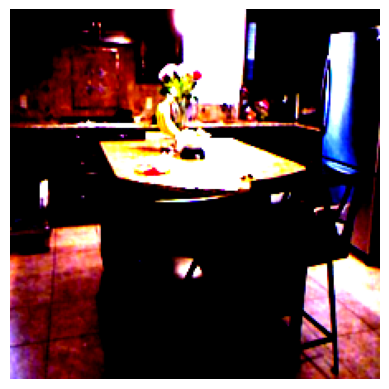

In [23]:
import matplotlib.pyplot as plt

sample_index = 10 
sample_image, sample_questions, sample_labels = train_dataset[sample_index]
sample_image_np = sample_image.permute(1, 2, 0).numpy()
plt.imshow(sample_image_np)
plt.axis('off')
plt.show()



In [24]:

print("Questions:")
for question_idx in sample_questions:
    question_text = idx_2_word.get(question_idx.item(), "UNKNOWN_WORD")
    if question_text == "UNKNOWN_WORD":
            continue
    print(question_text)

print("Labels:")
for label_idx in range(len(sample_labels)):
    if sample_labels[label_idx] == 1:
        label_text = idx_2_answer.get(label_idx, "UNKNOWN_ANSWER")
        if label_text == "UNKNOWN_ANSWER":
            continue
        print(label_text)
label_test = label_text

Questions:
what
is
found
on
the
right
side
Labels:
refridgerator


In [25]:
max_iterations = len(train_ds)

In [26]:
from tqdm import tqdm

In [27]:
log = {
    'train': {
        'loss': []
    },
    'val': {
        'loss': [],
        'wups': [],
        'accuracy-top1': [],
        'accuracy-top5': []
    }
}

In [28]:
epochs = 10
initial_lr = 1e-5

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
steps_to_reschedule = 10

In [31]:
current_loss = 999999

effective = 'effective.pth'
last_epoch = 'last.pth'

for epoch in range(epochs):
    model.train()
    train_loss = []
    for i, (images, questions, answers) in tqdm(enumerate(train_ds), total = max_iterations):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)

        optimizer.zero_grad()    
        output = model(images, questions)

        loss = loss_fn(output, answers)
        loss.backward()

        optimizer.step()
        train_loss.append(loss.data.item())
    
    if epoch % steps_to_reschedule == steps_to_reschedule - 1:
        scheduler.step()
    
    model.eval()
    total_correct, totals, valid_loss, total_wups = 0, 0, [], 0
    for i, (images, questions, answers) in tqdm(enumerate(val_ds)):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)
        output = model(images, questions)
        
        
        loss = loss_fn(output, answers)
        
        total_correct += (torch.max(output.data, 1)[1] == torch.max(answers.data, 1)[1]).float().sum()
        totals += answers.shape[0]
        valid_loss.append(loss.data.item())
        
    log['train']['loss'].append(torch.mean(torch.Tensor(train_loss)).item())
    
    val_loss = torch.mean(torch.Tensor(train_loss)).item()

    if val_loss < current_loss:
        current_loss = val_loss
        print('Save a checkpoint at epoch: ', epoch)
        torch.save(model.state_dict(), effective)
    
    log['val']['loss'].append(val_loss)
    log['val']['accuracy-top1'].append(total_correct / totals)
    
    print(f'Epoch {epoch} - training loss {log["train"]["loss"][-1]} - validation loss {log["val"]["loss"][-1]} - validation accuracy {log["val"]["accuracy-top1"][-1]}')

100%|██████████| 312/312 [01:10<00:00,  4.41it/s]
78it [00:17,  4.54it/s]


Save a checkpoint at epoch:  0
Epoch 0 - training loss 5.06663179397583 - validation loss 5.06663179397583 - validation accuracy 0.20328788459300995


100%|██████████| 312/312 [01:11<00:00,  4.38it/s]
78it [00:17,  4.51it/s]


Save a checkpoint at epoch:  1
Epoch 1 - training loss 4.573216915130615 - validation loss 4.573216915130615 - validation accuracy 0.21732157468795776


100%|██████████| 312/312 [01:10<00:00,  4.40it/s]
78it [00:17,  4.54it/s]


Save a checkpoint at epoch:  2
Epoch 2 - training loss 4.2077789306640625 - validation loss 4.2077789306640625 - validation accuracy 0.24739374220371246


100%|██████████| 312/312 [01:11<00:00,  4.37it/s]
78it [00:16,  4.60it/s]


Save a checkpoint at epoch:  3
Epoch 3 - training loss 3.8955748081207275 - validation loss 3.8955748081207275 - validation accuracy 0.26263031363487244


100%|██████████| 312/312 [01:10<00:00,  4.43it/s]
78it [00:16,  4.60it/s]


Save a checkpoint at epoch:  4
Epoch 4 - training loss 3.5484509468078613 - validation loss 3.5484509468078613 - validation accuracy 0.2662389874458313


100%|██████████| 312/312 [01:10<00:00,  4.40it/s]
78it [00:16,  4.64it/s]


Save a checkpoint at epoch:  5
Epoch 5 - training loss 3.239121675491333 - validation loss 3.239121675491333 - validation accuracy 0.2630312740802765


100%|██████████| 312/312 [01:11<00:00,  4.38it/s]
78it [00:17,  4.54it/s]


Save a checkpoint at epoch:  6
Epoch 6 - training loss 2.907296895980835 - validation loss 2.907296895980835 - validation accuracy 0.2706495523452759


100%|██████████| 312/312 [01:10<00:00,  4.41it/s]
78it [00:17,  4.55it/s]


Save a checkpoint at epoch:  7
Epoch 7 - training loss 2.597012996673584 - validation loss 2.597012996673584 - validation accuracy 0.2662389874458313


100%|██████████| 312/312 [01:10<00:00,  4.43it/s]
78it [00:17,  4.52it/s]


Save a checkpoint at epoch:  8
Epoch 8 - training loss 2.3130722045898438 - validation loss 2.3130722045898438 - validation accuracy 0.2610264718532562


100%|██████████| 312/312 [01:10<00:00,  4.43it/s]
78it [00:17,  4.58it/s]


Save a checkpoint at epoch:  9
Epoch 9 - training loss 2.0531444549560547 - validation loss 2.0531444549560547 - validation accuracy 0.2746591866016388


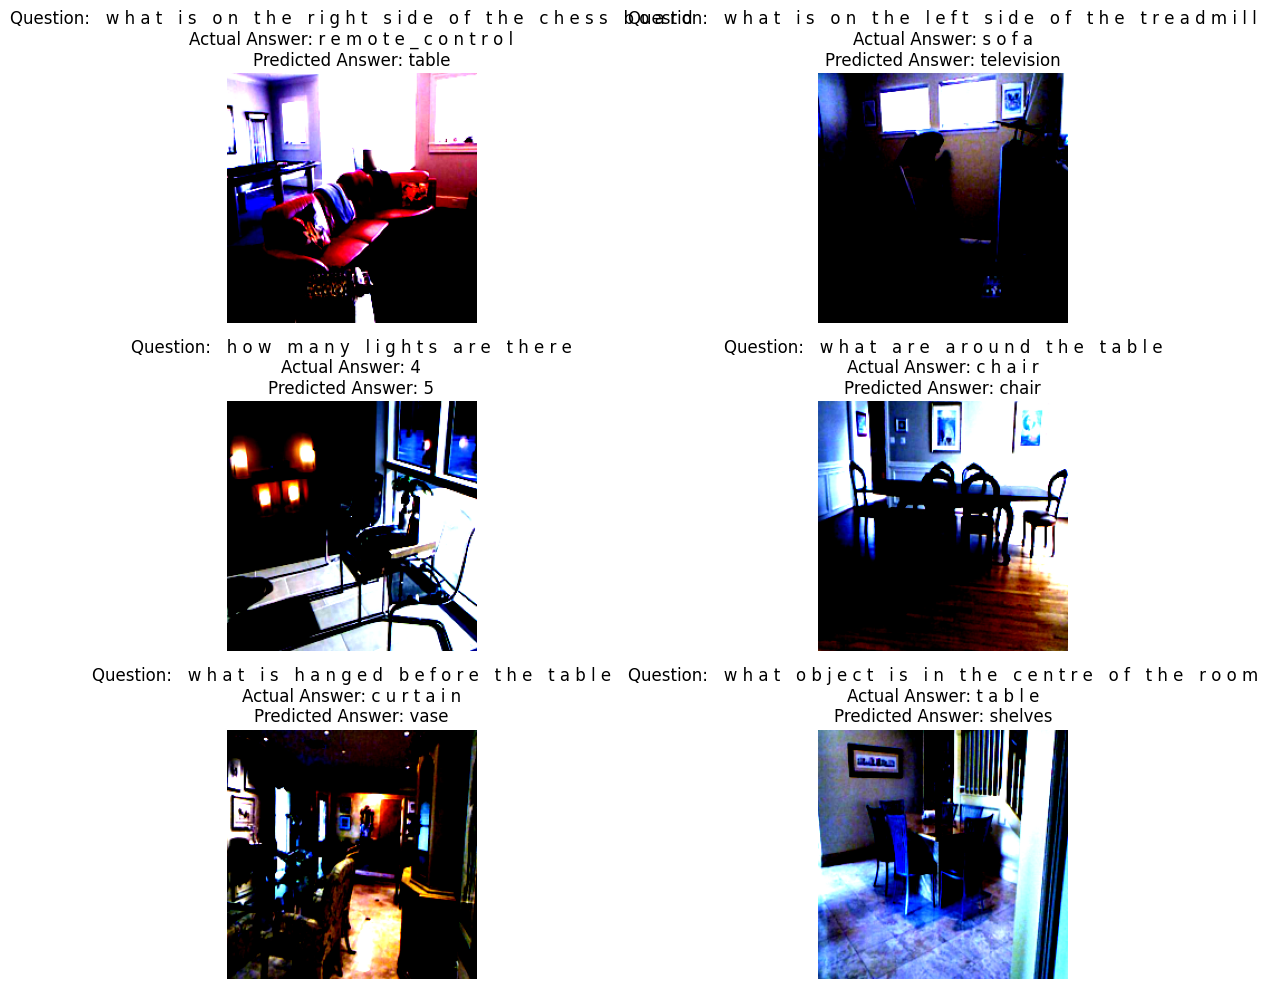

In [34]:
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def output_to_answer(output):
    _, predicted_idx = torch.max(output, -1)
    predicted_answer = idx_2_answer.get(predicted_idx.item(), "UNKNOWN_ANSWER")
    return predicted_answer

num_rows = 3
num_cols = 2

num_samples = num_rows * num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, (images, questions, answers) in enumerate(val_ds):
    if i == num_samples:
        break
    
    images = images.to(device)
    questions = questions.to(device)
    
    outputs = model(images, questions)
    image_np = images.cpu().numpy()[0].transpose(1, 2, 0)
    
    question_text = ''
    for question_idx in questions[0]:
        q_text = idx_2_word.get(question_idx.item(), "UNKNOWN_WORD")
        if q_text == "UNKNOWN_WORD":
            continue
        question_text += ' '+q_text
    
    actual_answer_indices = [idx for idx, val in enumerate(answers[0]) if val == 1]
    actual_answer = [idx_2_answer.get(idx, "UNKNOWN_ANSWER") for idx in actual_answer_indices][0]
    predicted_answer = output_to_answer(outputs[0])
    
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    ax = axes[row_idx, col_idx]
    ax.imshow(image_np)
    ax.axis('off')
    ax.set_title(f"Question: {' '.join(question_text)}\nActual Answer: {' '.join(actual_answer)}\nPredicted Answer: {predicted_answer}")

plt.tight_layout()
plt.show()


In [ ]:
print('Saving model to', last_epoch)
torch.save(model.state_dict(), last_epoch)

### Acknowledgments

We extend our gratitude to the numerous sources and contributors whose work has been invaluable in the development of this project. While it's not feasible to name each one individually, we acknowledge the collective efforts of researchers, educators, developers, and open-source communities whose work has laid the foundation for our endeavors. We are indebted to the wealth of knowledge shared through research papers, online forums, tutorials, and code repositories, which have guided and inspired our work.

Lastly, we thank our colleagues, mentors, and peers for their support, feedback, and collaboration throughout this journey. Their insights and encouragement have been instrumental in shaping our ideas and refining our approaches.